In [40]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots

In [41]:
function PLUGIn_denoise(G,y, max_iter, stepsize, tolerance, out_toggle)
    
  (_, z_dim) = size(Flux.params(G[1])[1]);
  W = I(z_dim)

  #normalize the weights of the network
  for i in 1:length(G)
      _, s, _ = svd(Flux.params(G[i])[1])
      W = Flux.params(G[i])[1] * W /s[1]
  end

  z = randn(z_dim)
  iter = 1
  succ_error = 1

  while iter <= max_iter && succ_error > tolerance
    
    # d gives the PLUGIn direction
    d = W'*(G(z) - y)
    z -= stepsize * d
    succ_error = norm(stepsize * d)
    if iter % out_toggle == 0  
        println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
    end
    iter += 1
  end
  println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")

  return z
end

PLUGIn_denoise (generic function with 1 method)

In [46]:
function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

reconstruct_images (generic function with 1 method)

In [42]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)

z = randn(20)
y = G(z) + 1e-14 * randn(784)

stepsize = 20
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
z_rec = PLUGIn_denoise(G,y, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - z_rec)
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

====> In quasi-gradient: Iteration: 158 Successive error: 9.254386942206372e-15
recovery error: 4.4972011807763817e-13, reconstruction error: 1.320877057355777e-13


Loading model...Done
====> In quasi-gradient: Iteration: 10001 Successive error: 0.21396272904642546
PLUGIn: reconstruction error: 6.242903237530242


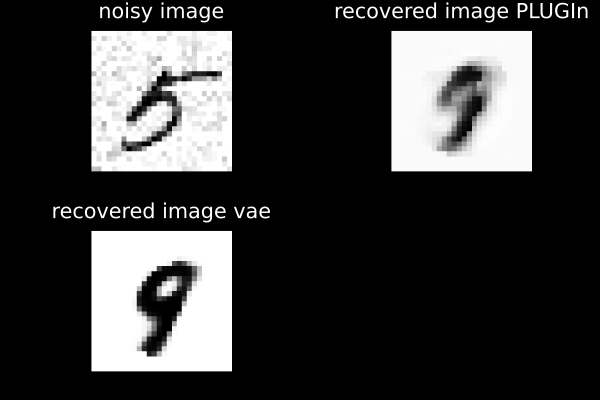

In [76]:
# experiments with MNIST dataset

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 13
# Load the model and test set loader
load_dir = "result/MNIST"
encoder_mu, encoder_logvar, decoder = load_model(load_dir, epoch_to_load)

# pick a image in MNIST to denoise
num = 5
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i];

noise_level = .1
y = x + noise_level * randn(784)

stepsize = .4
tolerance = 1e-7
max_iter = 10000
out_toggle = 100
z_rec = PLUGIn_denoise(decoder, y, max_iter, stepsize, tolerance, 1000001)
error = norm(x - decoder(z_rec))
println("PLUGIn: reconstruction error: $error")

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec), 28,28)' )

recovered_image_vae = colorview(Gray, reshape(reconstruct_images(encoder_mu, encoder_logvar, decoder, y) , 28,28)' )


noisy_image = colorview(Gray, reshape(y, 28,28)' );
p1 = plot(noisy_image, framestyle = :none, bg =:black, title = "noisy image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn")
p3 = plot(recovered_image_vae, framestyle = :none, bg =:black, title = "recovered image vae")
plot(p1, p2, p3, layout = 3)


Loading model...Done
====> In quasi-gradient: Iteration: 1001 Successive error: 1.9445978189102955
PLUGIn: reconstruction error: 6.255240942553061


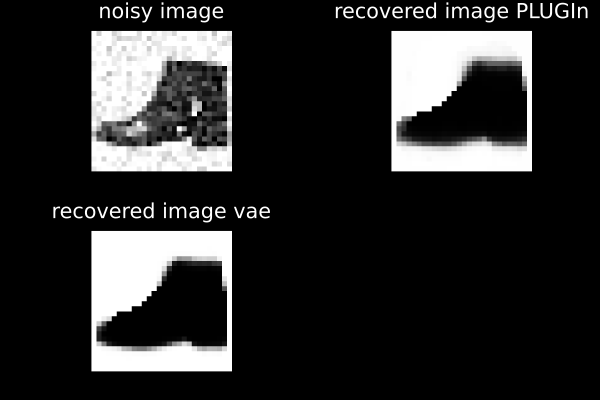

In [79]:
# experiments with FashionMNIST dataset

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The FashionMNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = FashionMNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 9
# Load the model and test set loader
load_dir = "result/FashionMNIST"
encoder_mu, encoder_logvar, decoder = load_model(load_dir, epoch_to_load)

# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i];

noise_level = .1
y = x + noise_level * randn(784)

stepsize = .4
tolerance = 1e-7
max_iter = 1000
out_toggle = 100
z_rec = PLUGIn_denoise(decoder, y, max_iter, stepsize, tolerance, 1000001)
error = norm(x - decoder(z_rec))
println("PLUGIn: reconstruction error: $error")

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec), 28,28)' )

recovered_image_vae = colorview(Gray, reshape(reconstruct_images(encoder_mu, encoder_logvar, decoder, y) , 28,28)' )


noisy_image = colorview(Gray, reshape(y, 28,28)' );
p1 = plot(noisy_image, framestyle = :none, bg =:black, title = "noisy image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn")
p3 = plot(recovered_image_vae, framestyle = :none, bg =:black, title = "recovered image vae")
plot(p1, p2, p3, layout = 3)




